<a href="https://colab.research.google.com/github/ahmednashaat30900/Credit_Card_Users_Segmentation/blob/main/Crediet_Card_Clustering_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage,dendrogram
import plotly.graph_objects as go
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

## 2.Load Data

In [6]:
df = pd.read_csv('credit_card_data.csv')

## 3.Normalizing Data

1.Drop Unnecessary columns

In [7]:
df = df.drop(['CUST_ID'], axis=1)


2.Missing Values

In [8]:
df.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

There are 313 missing values in MINIMUM_PAYMENTS and 1 missing value in CREDIT_LIMIT.

In [9]:
df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].mean(),inplace=True)
df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].mean(),inplace=True)

Fill those values with the mean of the respective columns.

 3.Outliers

3.1 Detecting Outliers


BALANCE
lower_bound is -2760.5052645
upper_bound is 3017.0690955000005
Q1 is : 128.2819155
Q3 is : 2054.1400355
1434 of 8950 is outlier (%16.02)

PURCHASES
lower_bound is -1566.1075000000003
upper_bound is 1645.3775000000003
Q1 is : 39.635
Q3 is : 1110.13
1539 of 8950 is outlier (%17.2)

ONEOFF_PURCHASES
lower_bound is -866.1075
upper_bound is 866.1075
Q1 is : 0.0
Q3 is : 577.405
1703 of 8950 is outlier (%19.03)

INSTALLMENTS_PURCHASES
lower_bound is -702.95625
upper_bound is 702.95625
Q1 is : 0.0
Q3 is : 468.6375
1561 of 8950 is outlier (%17.44)

CASH_ADVANCE
lower_bound is -1670.7317088750003
upper_bound is 1670.7317088750003
Q1 is : 0.0
Q3 is : 1113.8211392500002
1717 of 8950 is outlier (%19.18)

CREDIT_LIMIT
lower_bound is -5750.0
upper_bound is 8950.0
Q1 is : 1600.0
Q3 is : 6500.0
1129 of 8950 is outlier (%12.61)

PAYMENTS
lower_bound is -1893.5110601250003
upper_bound is 2660.0633921250005
Q1 is : 383.276166
Q3 is : 1901.1343167500002
1512 of 8950 is outlier (%16.89)

MINIMUM_PA

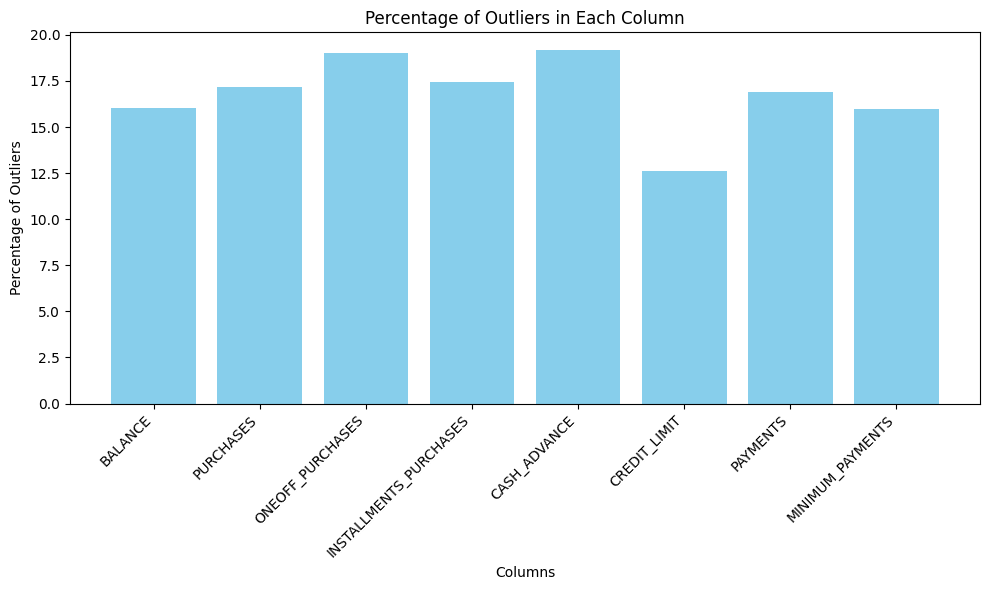

In [10]:
import matplotlib.pyplot as plt

columns = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
           'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']

outliers_percentage = []

for c in columns:
    df_table = df[c].copy()
    Q1 = df_table.quantile(0.25)
    Q3 = df_table.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q1 + 1.5 * IQR

    outliers_number = ((df_table < lower_bound) | (df_table > upper_bound)).sum()

    percentage = round((100 * outliers_number) / len(df_table), 2)
    outliers_percentage.append(percentage)

    print("\n" + c)
    print("lower_bound is " + str(lower_bound))
    print("upper_bound is " + str(upper_bound))
    print("Q1 is : " + str(Q1))
    print("Q3 is : " + str(Q3))
    print(str(outliers_number) + " of " + str(len(df_table)) + " is outlier (%" + str(percentage) + ")")

# Plotting the percentage of outliers for each column with rotated x-axis labels
plt.figure(figsize=(10, 6))
plt.bar(columns, outliers_percentage, color='skyblue')
plt.title('Percentage of Outliers in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Outliers')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


3.2 Removing Outliers

In [11]:
#removing outlier except for the last column
for i in df.iloc[:,:-1]:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    up_lim = Q3 + 1.5 * IQR
    low_lim = Q1 - 1.5 * IQR
    df.loc[df[i] > up_lim,i] = up_lim
    df.loc[df[i] < low_lim,i] = low_lim

## 4.Apply K-Means without RFE

 1.Ploting Data

In [12]:
import plotly.graph_objects as go

PLOT = go.Figure()

PLOT.add_trace(go.Scatter3d(
    x=df['BALANCE'],
    y=df['PURCHASES'],
    z=df['CREDIT_LIMIT'],
    mode='markers',
    marker=dict(size=6, line=dict(width=1)),
    hovertemplate='BALANCE: %{x} <br>PURCHASES %{y} <br>CREDIT_LIMIT: %{z}'
))

PLOT.update_layout(
    width=800,
    height=800,
    autosize=True,
    showlegend=False,  # Remove legend for a cleaner plot
    scene=dict(
        xaxis=dict(title='BALANCE', titlefont_color='black'),
        yaxis=dict(title='PURCHASES', titlefont_color='black'),
        zaxis=dict(title='CREDIT_LIMIT', titlefont_color='black')
    ),
    font=dict(family="Gilroy", color='black', size=12)
)

PLOT.show()


2. Choosing features

In [13]:
clustering_data = df[["BALANCE", "PURCHASES", "CREDIT_LIMIT"]]

 3.Determine Best K value

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

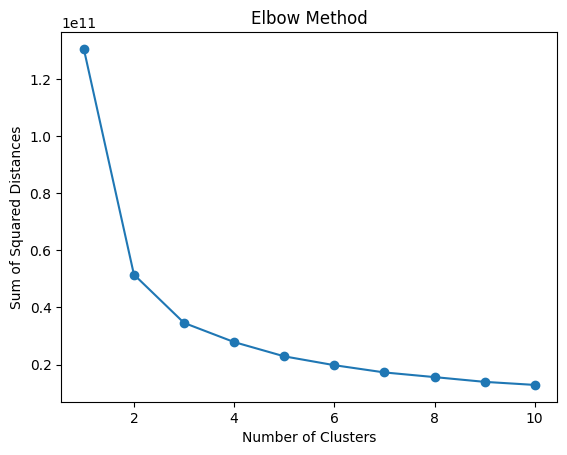

In [ ]:
X = clustering_data.values

# elbow method
def elbow_method(X, max_clusters):
    sse = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        sse.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters+1), sse, marker='o')  # Add marker='o' to display points
    plt.title("Elbow Method")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Distances")
    plt.show()

elbow_method(X, 10)


 4.Applying K-Means Algorithm

In [14]:
for i in clustering_data.columns:
    MinMaxScaler(i)

kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(clustering_data)
df["CREDIT_CARD_SEGMENTS"] = clusters
labels=kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



5. Add clusters column

In [15]:
df["CREDIT_CARD_SEGMENTS"] = df["CREDIT_CARD_SEGMENTS"].map({0: "Cluster 1", 1:
    "Cluster 2", 2: "Cluster 3", 3: "Cluster 4"})
print(df["CREDIT_CARD_SEGMENTS"].value_counts())


Cluster 1    5240
Cluster 3    1682
Cluster 4    1118
Cluster 2     910
Name: CREDIT_CARD_SEGMENTS, dtype: int64


6. plotting Output


In [16]:
#plot the clusters on a 3D graph using Plotly

PLOT = go.Figure()
for i in list(df["CREDIT_CARD_SEGMENTS"].unique()):


    PLOT.add_trace(go.Scatter3d(x = df[df["CREDIT_CARD_SEGMENTS"]== i]['BALANCE'],
                                y = df[df["CREDIT_CARD_SEGMENTS"] == i]['PURCHASES'],
                                z = df[df["CREDIT_CARD_SEGMENTS"] == i]['CREDIT_LIMIT'],
                                mode = 'markers',marker_size = 6, marker_line_width = 1,
                                name = str(i)))
PLOT.update_traces(hovertemplate='BALANCE: %{x} <br>PURCHASES %{y} <br>DCREDIT_LIMIT: %{z}')


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'BALANCE', titlefont_color = 'black'),
                                yaxis=dict(title = 'PURCHASES', titlefont_color = 'black'),
                                zaxis=dict(title = 'CREDIT_LIMIT', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

7. Distribution of each feature at clusters

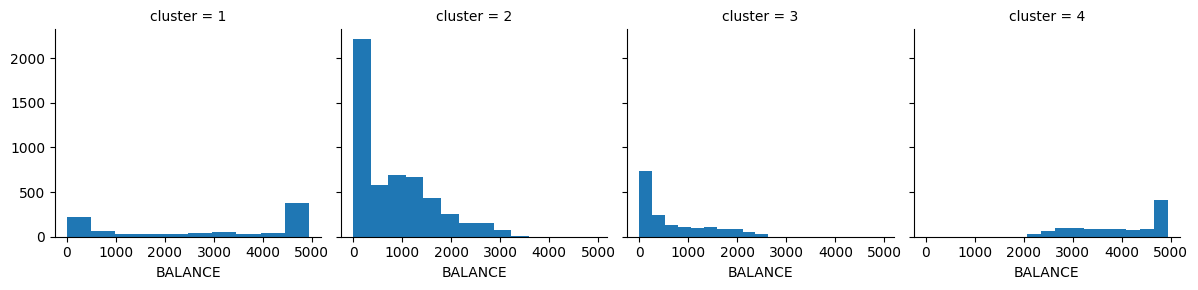

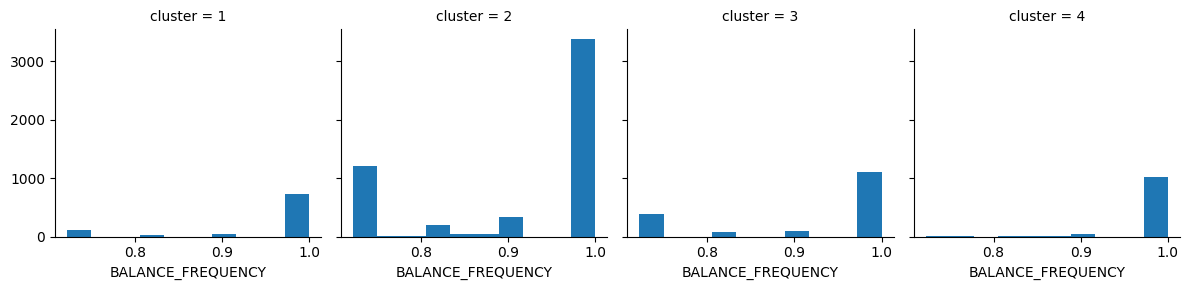

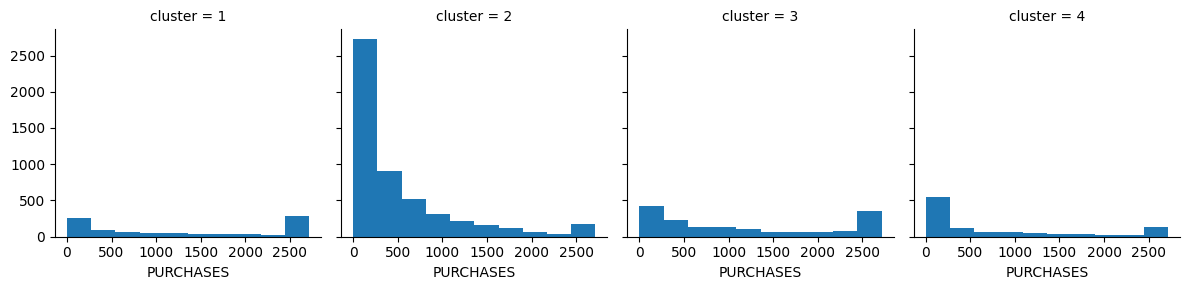

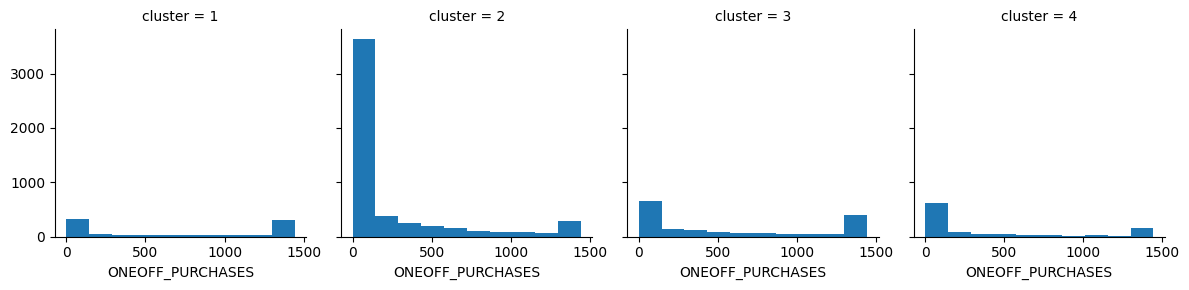

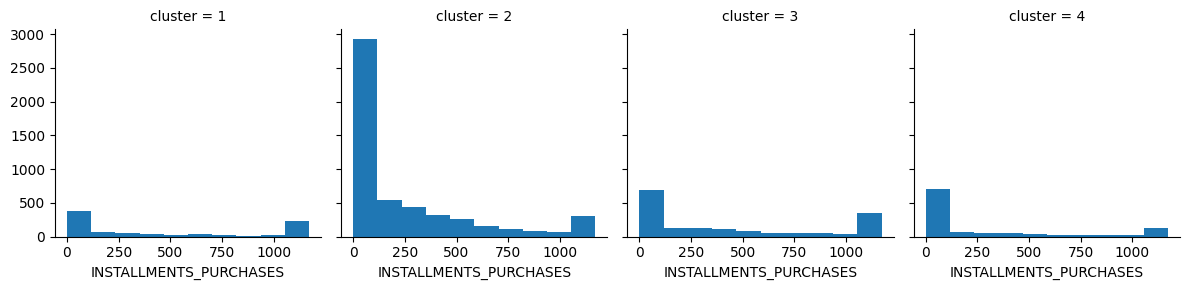

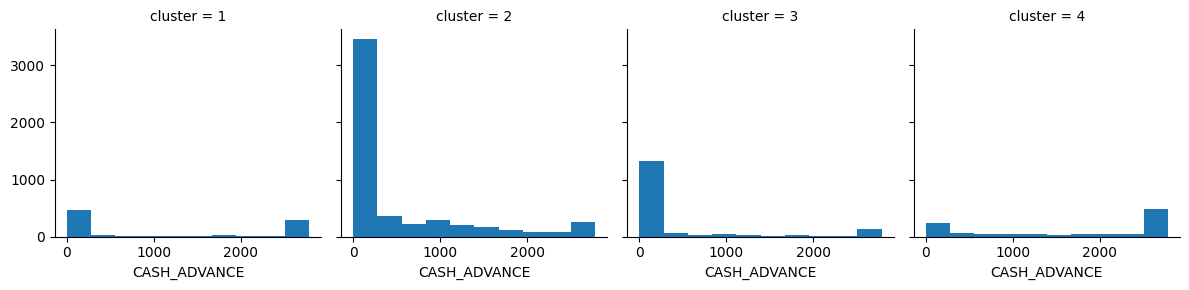

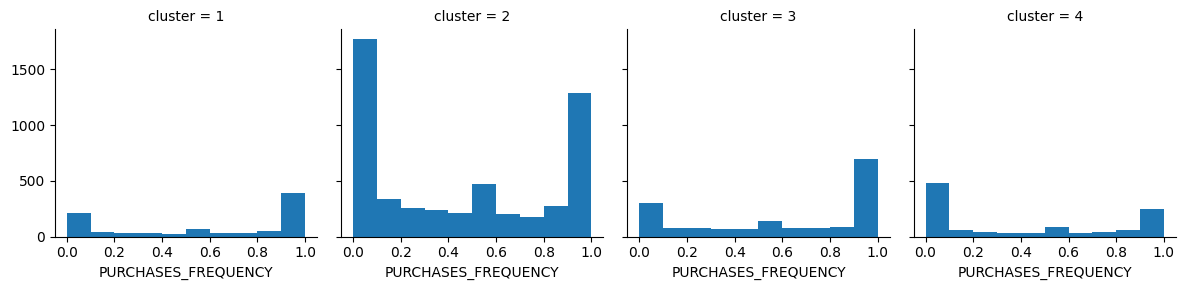

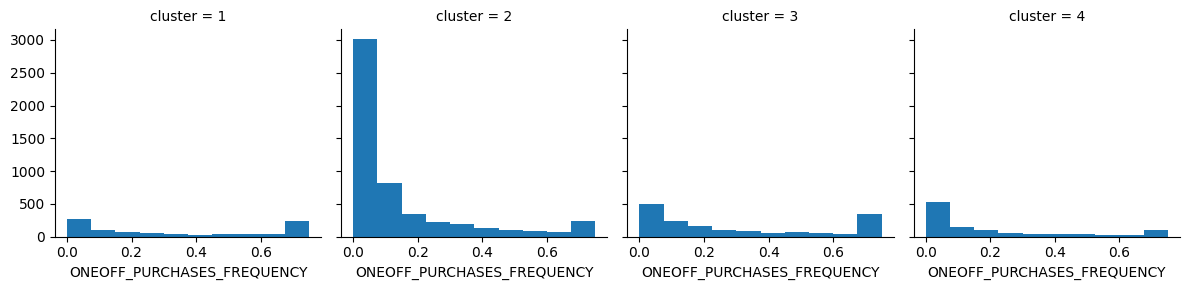

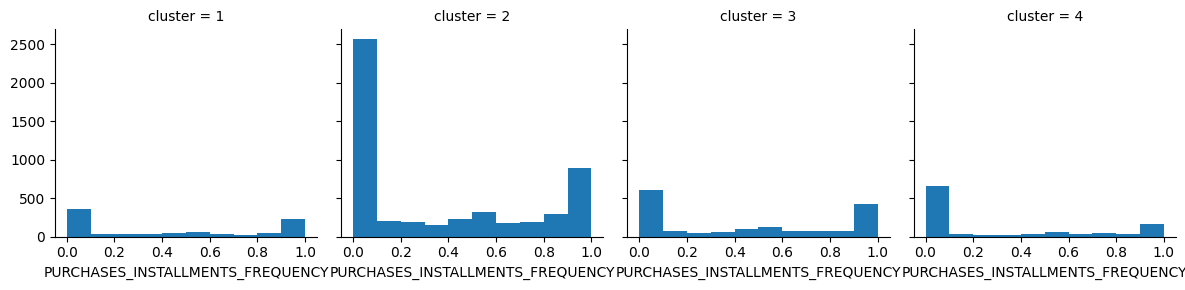

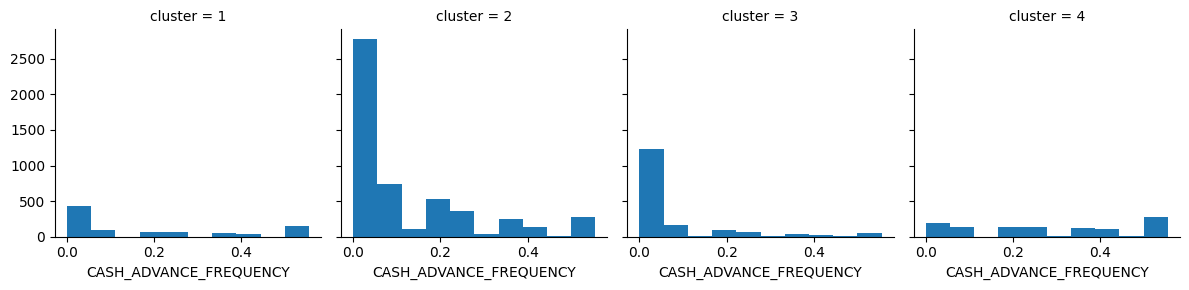

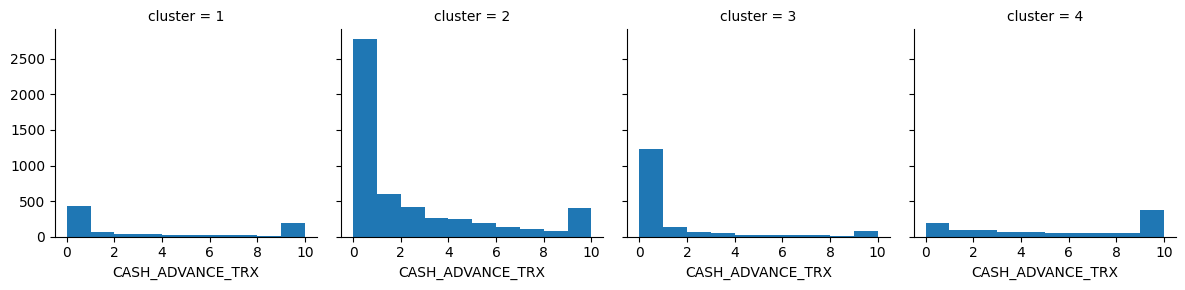

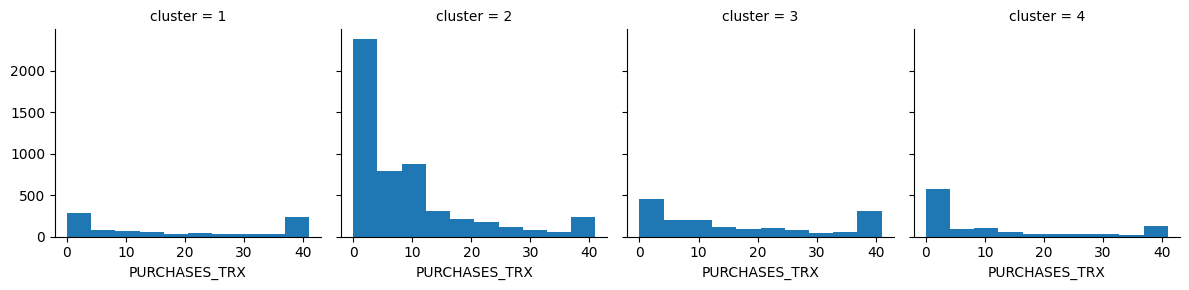

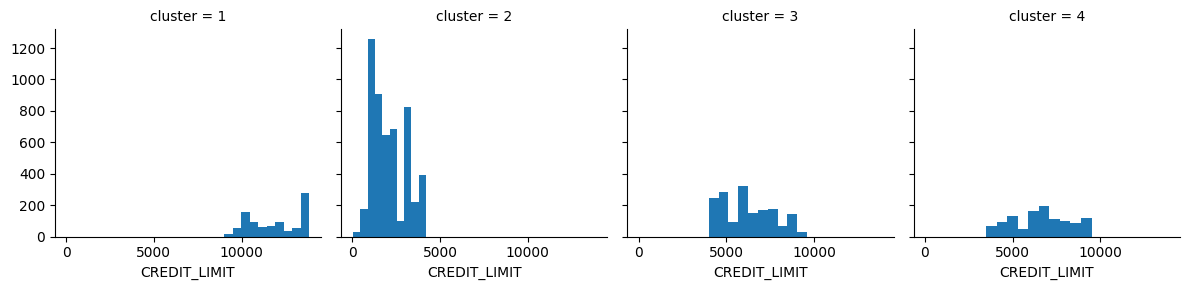

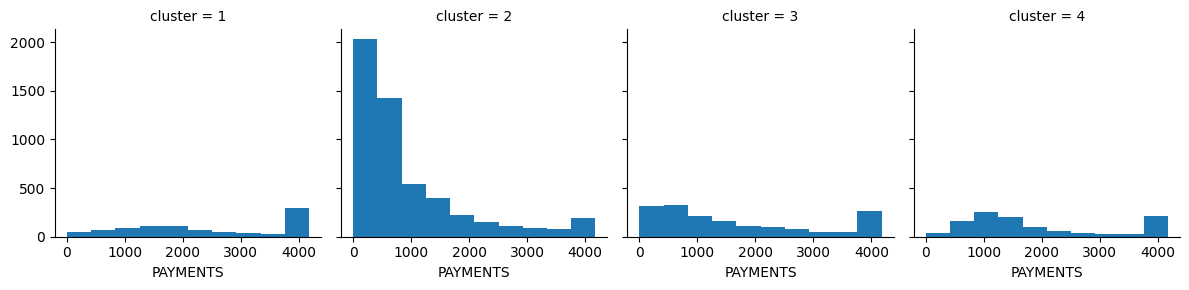

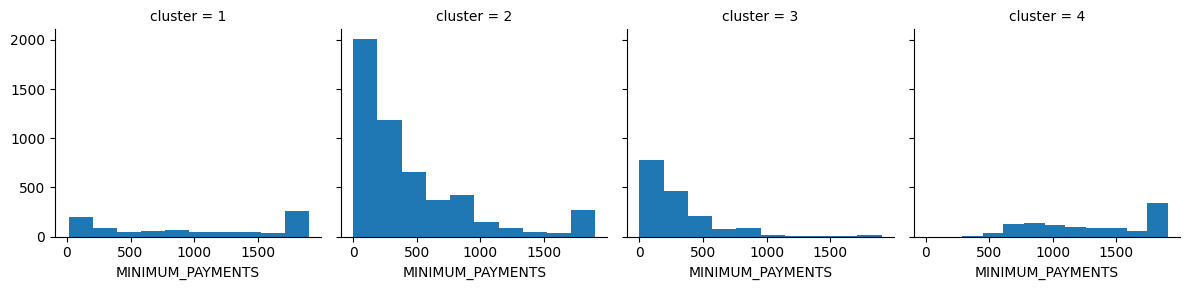

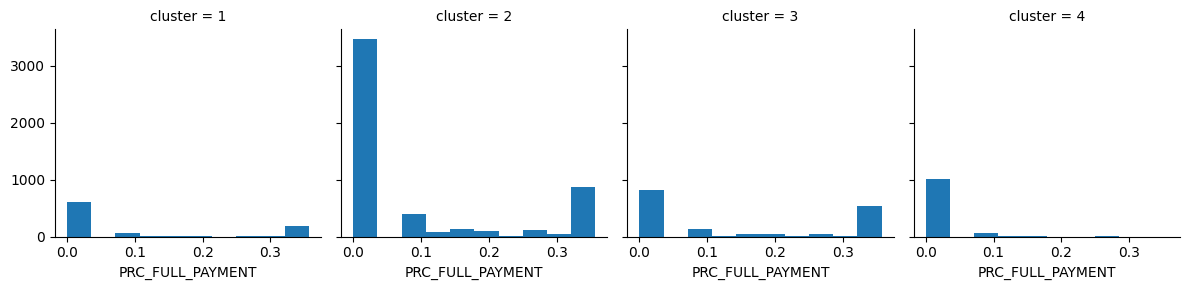

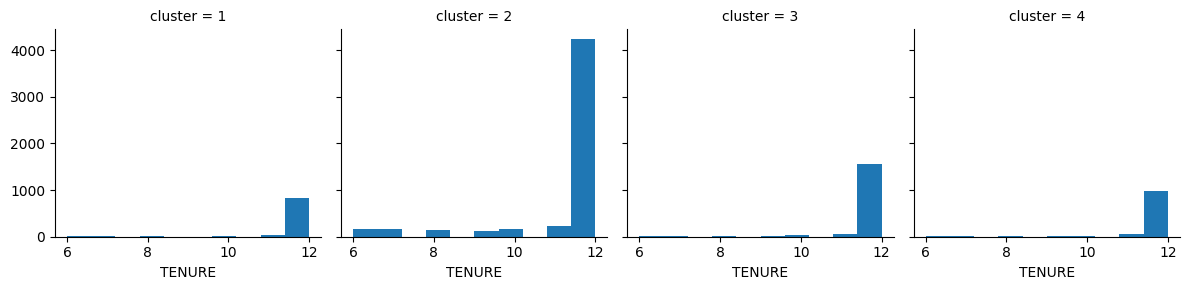

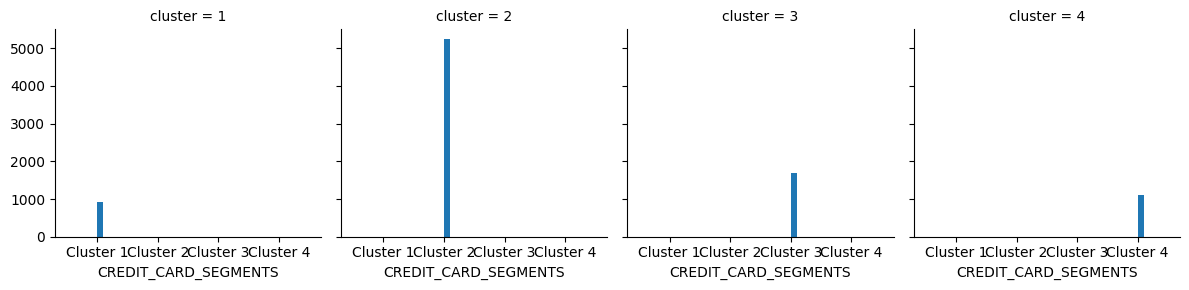

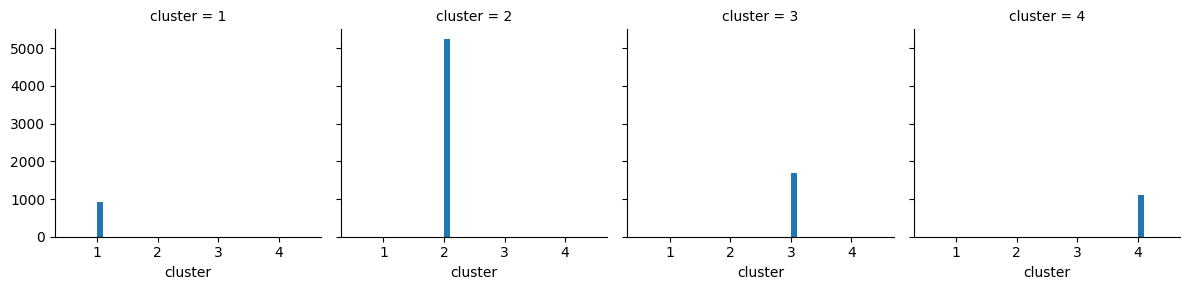

In [ ]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters['cluster'] = clusters['cluster'].replace({0: 1, 1:2, 2:3, 3:4})
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)

## Apply K-Means with RFE

1. Apply RFE

In [17]:

df= df.drop(['CREDIT_CARD_SEGMENTS'], axis=1)
# Choose an estimator (KMeans)
estimator = KMeans(n_clusters=4)  # You can change the number of clusters as needed

# Fit k-means on the data
estimator.fit(df)

# Get the cluster assignments for each sample
cluster_assignments = estimator.predict(df)

# Select the top k features based on mutual information
num_features_to_select = 3  # Adjust as needed
selector = SelectKBest(mutual_info_classif, k=num_features_to_select)
X_selected = selector.fit_transform(df, cluster_assignments)

# Print the selected features
selected_features = df.columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Selected Features: ['BALANCE', 'CREDIT_LIMIT', 'MINIMUM_PAYMENTS']


2. Apply K-Means foe selected feature

In [18]:
clustering_data = df[selected_features]
for i in clustering_data.columns:
    MinMaxScaler(i)

kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(clustering_data)
df["CREDIT_CARD_SEGMENTS"] = clusters
labels=kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



3. Add clusters column

In [19]:
df["CREDIT_CARD_SEGMENTS"] = df["CREDIT_CARD_SEGMENTS"].map({0: "Cluster 1", 1:
    "Cluster 2", 2: "Cluster 3", 3: "Cluster 4"})
print(df["CREDIT_CARD_SEGMENTS"].value_counts())



Cluster 1    5303
Cluster 3    1623
Cluster 4    1100
Cluster 2     924
Name: CREDIT_CARD_SEGMENTS, dtype: int64


4. Plotting the Results

In [20]:
#plot the clusters on a 3D graph using Plotly

PLOT = go.Figure()
for i in list(df["CREDIT_CARD_SEGMENTS"].unique()):


    PLOT.add_trace(go.Scatter3d(x = df[df["CREDIT_CARD_SEGMENTS"]== i]['BALANCE'],
                                y = df[df["CREDIT_CARD_SEGMENTS"] == i]['PURCHASES'],
                                z = df[df["CREDIT_CARD_SEGMENTS"] == i]['CREDIT_LIMIT'],
                                mode = 'markers',marker_size = 6, marker_line_width = 1,
                                name = str(i)))
PLOT.update_traces(hovertemplate='BALANCE: %{x} <br>PURCHASES %{y} <br>DCREDIT_LIMIT: %{z}')


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'BALANCE', titlefont_color = 'black'),
                                yaxis=dict(title = 'PURCHASES', titlefont_color = 'black'),
                                zaxis=dict(title = 'CREDIT_LIMIT', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

5. Distribution of each feature at the clusters

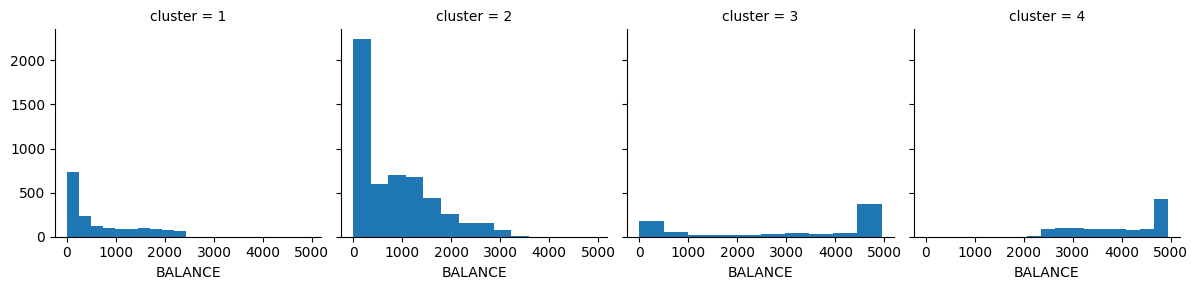

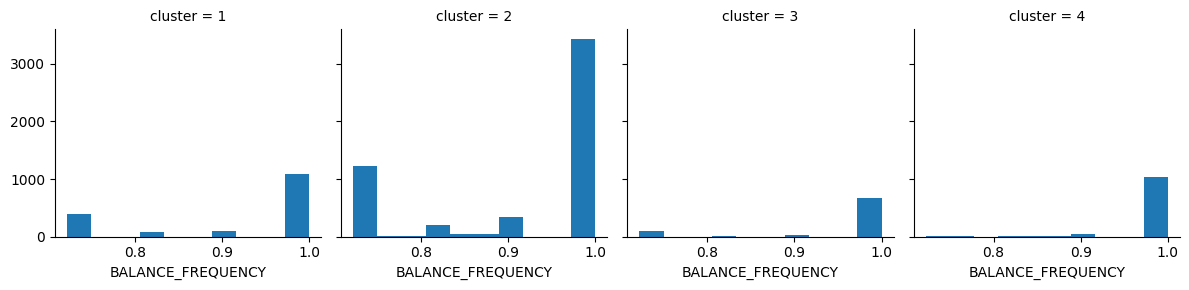

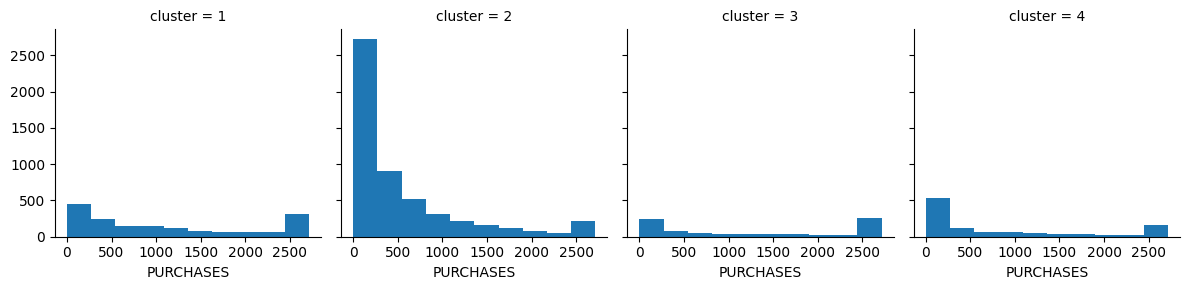

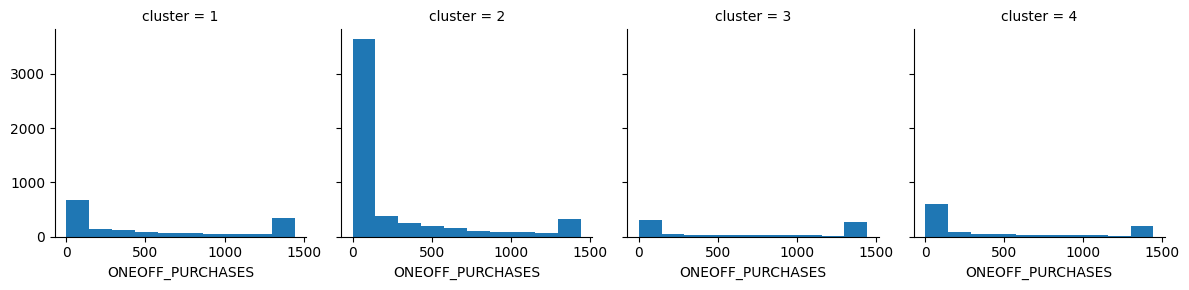

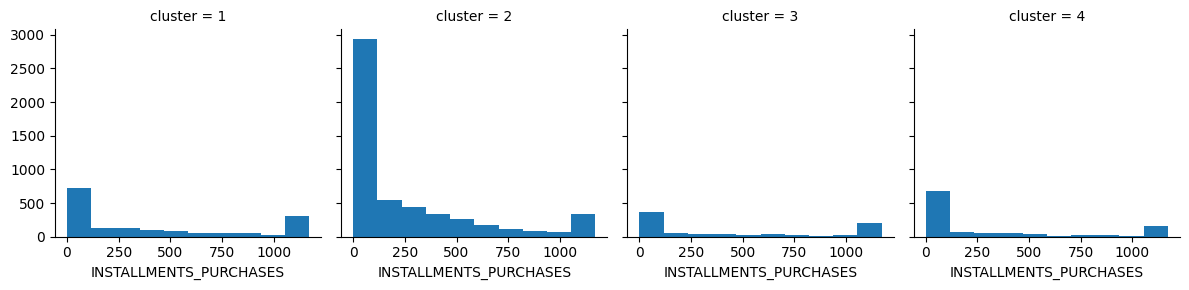

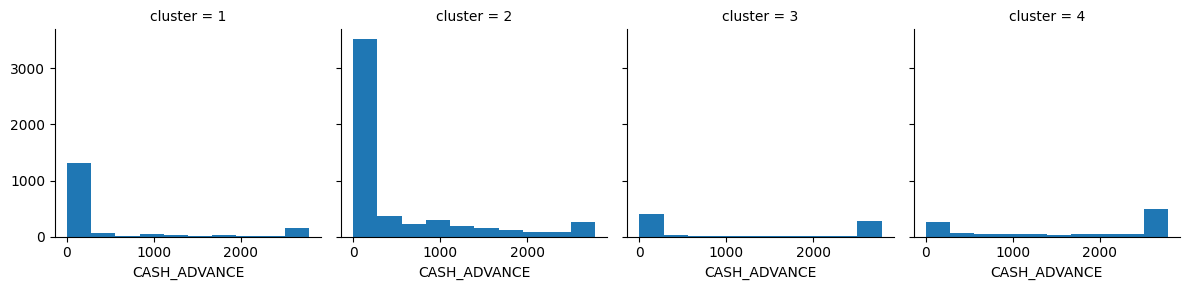

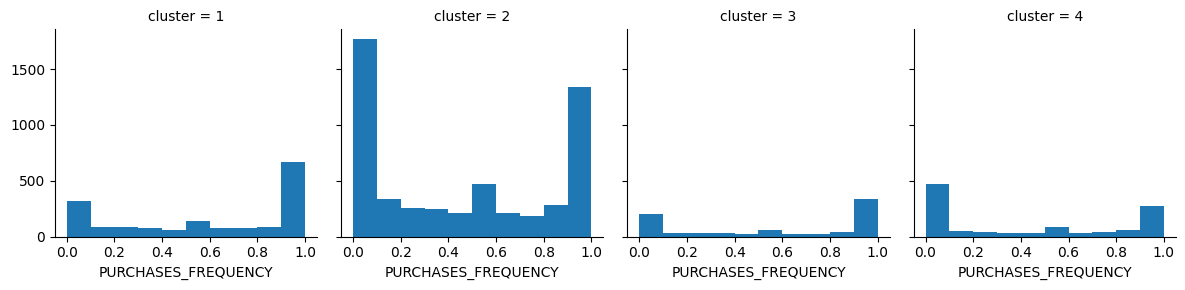

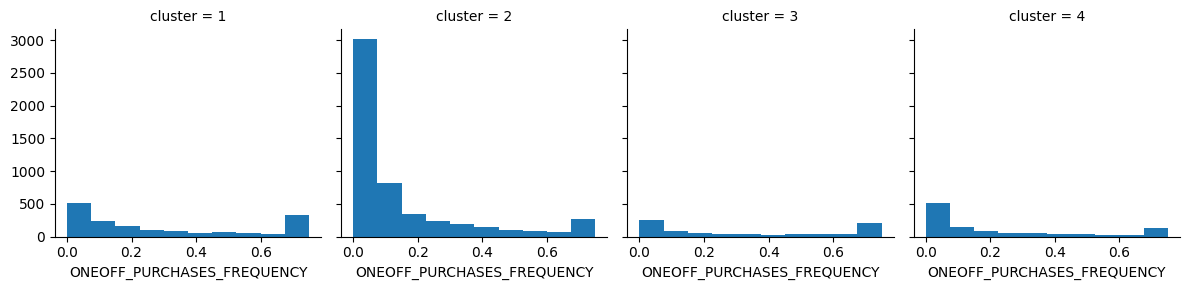

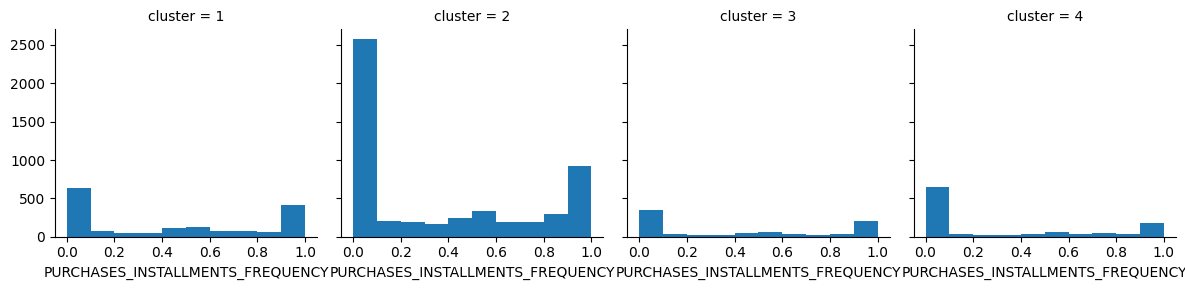

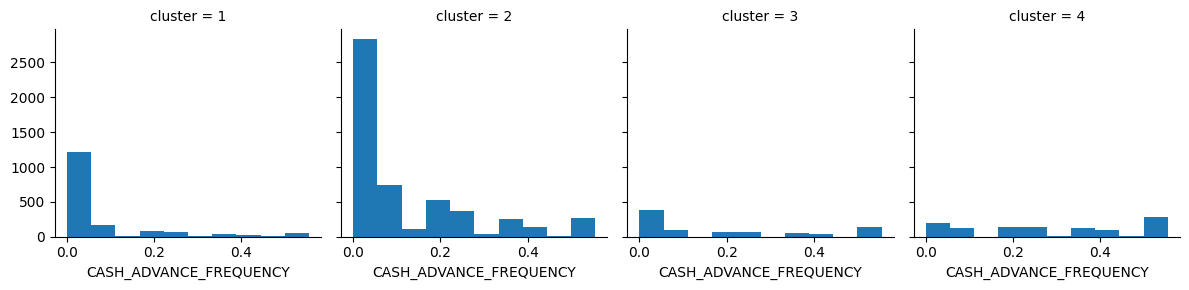

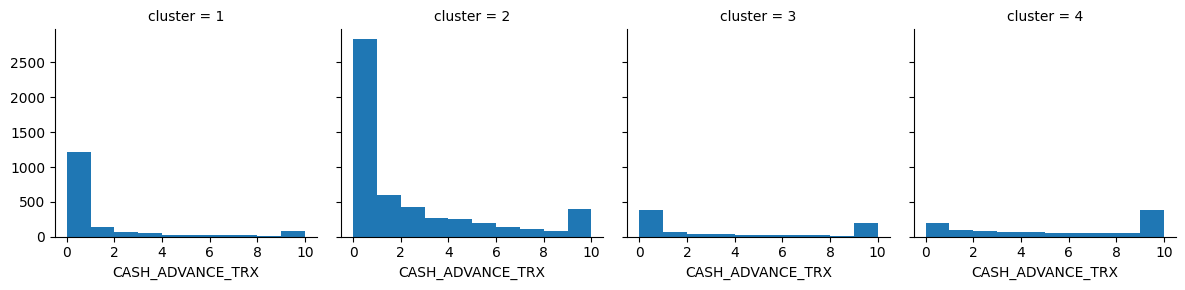

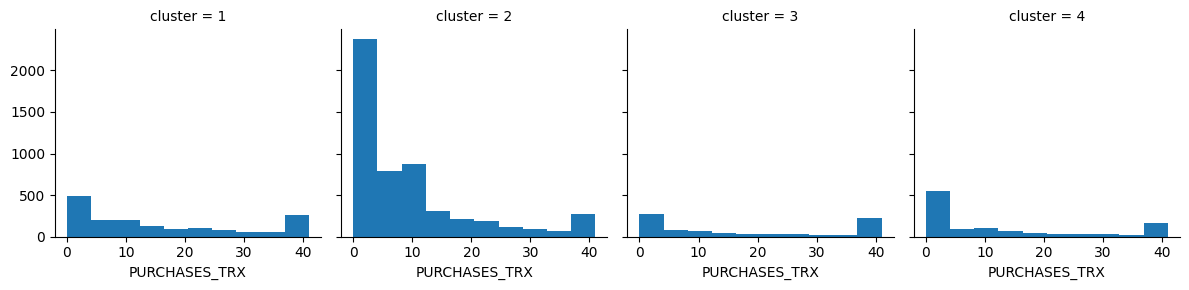

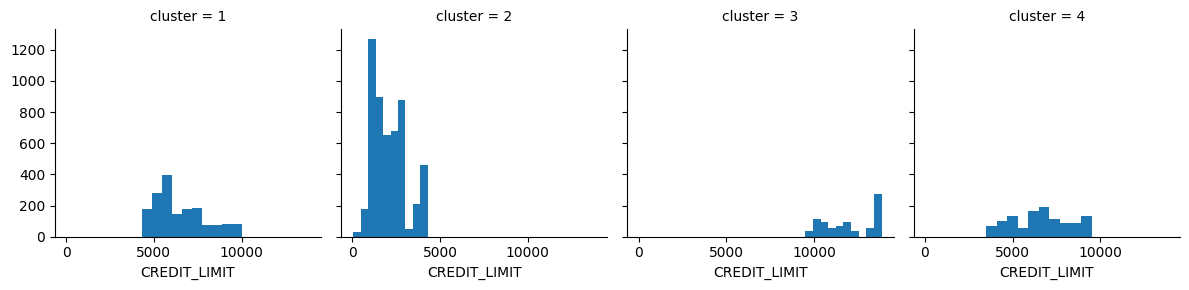

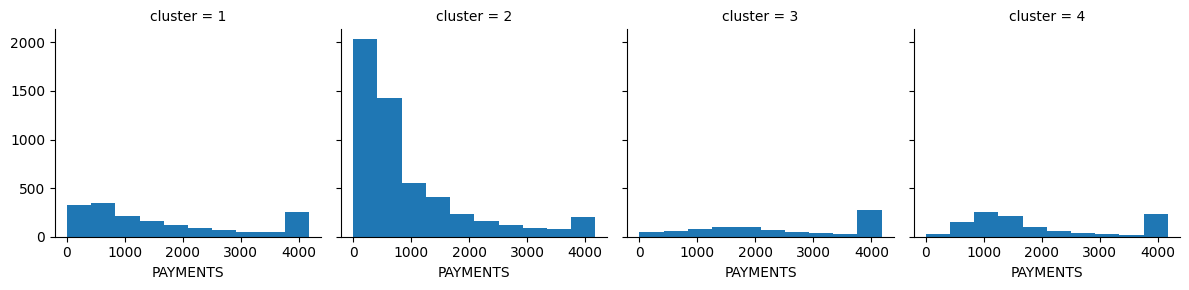

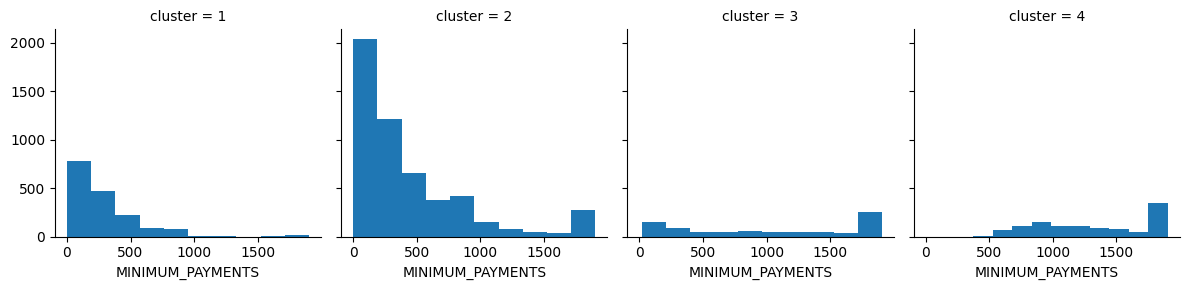

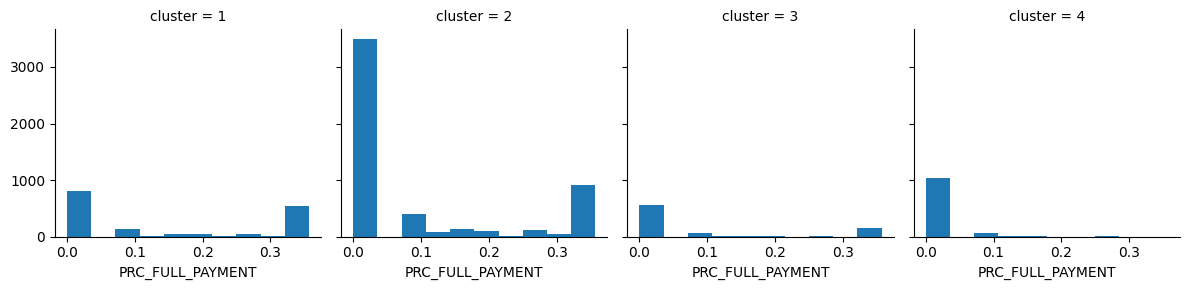

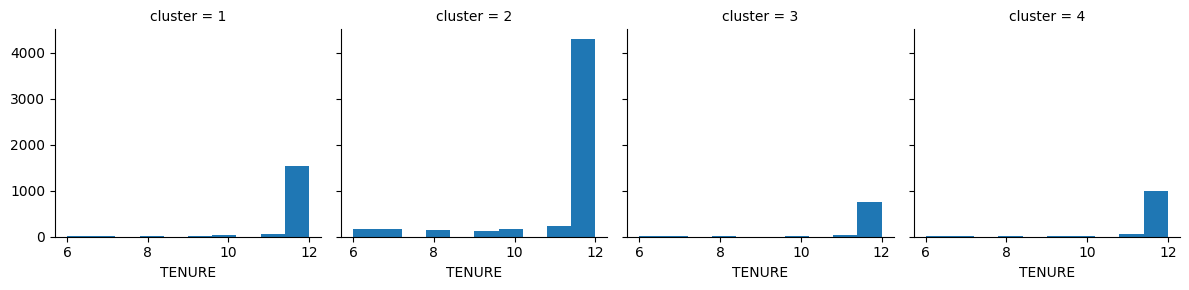

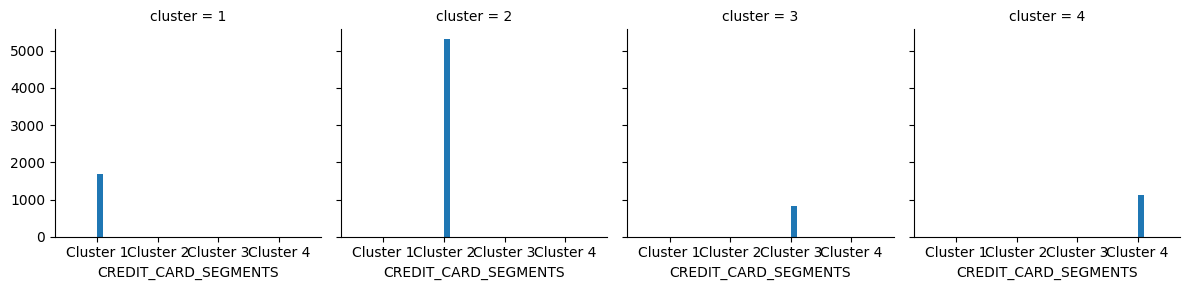

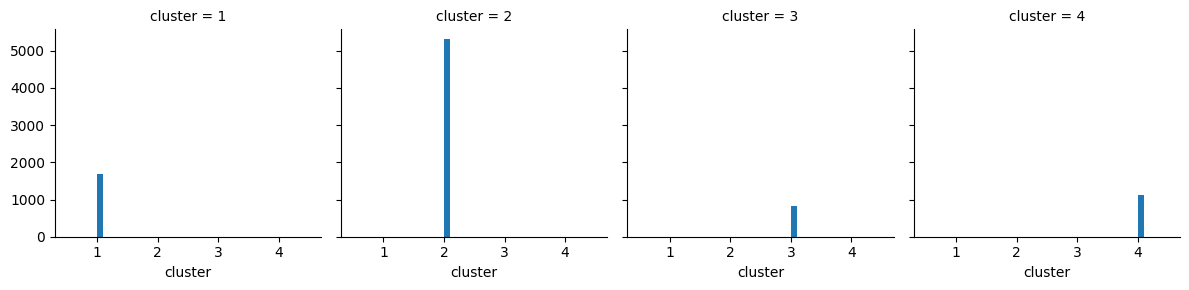

In [ ]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters['cluster'] = clusters['cluster'].replace({0: 1, 1:2, 2:3, 3:4})
for c in clusters:
    grid= sns.FacetGrid(clusters, col='cluster')
    grid.map(plt.hist, c)